# Getting Started with Voyage Multimodal Embeddings in Azure AI Search
This guide walks you through using the latest Voyage multimodal model for seamless vector search with both text and images.

## Setup and Prerequisites
- Azure Account: Ensure you have access to Azure AI Search.
- Voyage API Key: If you don’t have one, create it on Voyage’s website.

## Install Packages
In your notebook, install necessary packages:

In [ ]:
!pip install voyageai>=0.3.0 pandas PyMuPDF pillow numpy tenacity

## Authenticate Clients

In [40]:
import os
import voyageai
from voyageai import Client
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
import numpy as np
from PIL import Image
from io import BytesIO
import urllib.request
from voyageai import Client
import fitz  # PyMuPDF
from dotenv import load_dotenv
load_dotenv()
# Set up API keys and endpoints
VOYAGE_API_KEY = os.getenv("VOYAGE_API_KEY")  # Set your Voyage API key
AZURE_SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
AZURE_SEARCH_ADMIN_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "multimodal-voyage-index"

# Initialize Azure Search clients
azure_search_credential = AzureKeyCredential(AZURE_SEARCH_ADMIN_KEY)
index_client = SearchIndexClient(endpoint=AZURE_SEARCH_SERVICE_ENDPOINT, credential=azure_search_credential)
search_client = SearchClient(endpoint=AZURE_SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=azure_search_credential)

# Initialize Voyage client
voyage_client = voyageai.Client(api_key=VOYAGE_API_KEY)
MODEL_NAME = "voyage-multimodal-3"

## Generate Multimodal Embeddings
Voyage multimodal embeddings can vectorize interleaved text and images into a shared vector space.
Unlike traditional methods that process text and images separately, Voyage handles these as a unified representation.

In [38]:
def load_image_from_url(url: str, size: tuple = (256, 256)) -> Image.Image:
    """Helper function to load and resize images from URL."""
    with urllib.request.urlopen(url) as response:
        data = BytesIO(response.read())
    return Image.open(data).resize(size)

# Example image URL (replace with your image URL)
image_url = "https://portal.vision.cognitive.azure.com/dist/assets/ImageCaptioningSample1-bbe41ac5.png"
image = load_image_from_url(image_url)

# Basic text example
text = "The image showcases a peaceful rural scene with several cows leisurely grazing in a sunlit pasture."

# Generate embeddings for different input types
documents = [
    [text],           # Text only
    [image],          # Image only
    [text, image],    # Text followed by image
    [image, text]     # Image followed by text
]

result = voyage_client.multimodal_embed(
    inputs=documents,
    model=MODEL_NAME,
    input_type="document"
)

print("Number of embeddings:", len(result.embeddings))
print("Text tokens used:", result.text_tokens)
print("Image pixels processed:", result.image_pixels)
print("Total tokens:", result.total_tokens)

Number of embeddings: 4
Text tokens used: 55
Image pixels processed: 196608
Total tokens: 406


## Compare Embeddings


In [39]:
def cosine_similarity(v1, v2):
    """Calculate cosine similarity between two vectors."""
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Compare similarities between different combinations of documents
similarities = []
for i in range(len(result.embeddings)):
    for j in range(i + 1, len(result.embeddings)):
        sim = cosine_similarity(result.embeddings[i], result.embeddings[j])
        similarities.append((i, j, sim))

# Display similarity results
print("\nSimilarity Analysis:")
for i, j, sim in similarities:
    print(f"Similarity between document {i} and {j}: {sim:.4f}")


Similarity Analysis:
Similarity between document 0 and 1: 0.6536
Similarity between document 0 and 2: 0.8529
Similarity between document 0 and 3: 0.8049
Similarity between document 1 and 2: 0.8546
Similarity between document 1 and 3: 0.9080
Similarity between document 2 and 3: 0.9675


Here is the image jpg from above: 
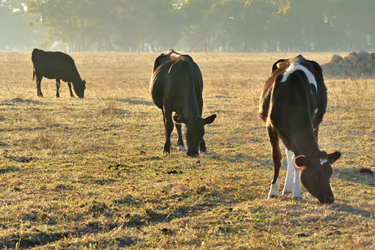

### Analysis of Cosine Similarity Scores Between Document Combinations

| Combination                    | Similarity Score | Analysis                                                                                              |
|---------------------------------|------------------|-------------------------------------------------------------------------------------------------------|
| **0 vs 1 (Text vs Image)**     | 0.6536           | Lowest similarity score, indicating different representations in the embedding space.                 |
| **0 vs 2 (Text vs Text+Image)** | 0.8529           | High similarity, showing strong preservation of text's semantic meaning in the embedding.             |
| **0 vs 3 (Text vs Image+Text)** | 0.8049           | High similarity, but slightly lower than text vs text+image, suggesting moderate influence of image-first order. |
| **1 vs 2 (Image vs Text+Image)** | 0.8546           | Strong similarity, indicating effective capture of image content even when combined with text.        |
| **1 vs 3 (Image vs Image+Text)** | 0.9080           | Higher similarity than image vs text+image, confirming that leading with the image strengthens its representation. |
| **2 vs 3 (Text+Image vs Image+Text)** | 0.9675       | Highest similarity score, demonstrating that both interleaved combinations capture very similar semantic content. |

### Conclusion

The pattern of similarity scores suggests that the model creates rich semantic embeddings that effectively combine both textual and visual modalities. However, the order of presentation has a moderate impact on the final embedding, with text-first and image-first orders influencing the representation differently. Overall, the model shows a strong ability to preserve semantic meaning across different combinations of text and image content.


## Chart and Figure Understanding

In [7]:
chart_text = "Margin of victory over past elections, in Minnesota. For the Minnesota Star Tribune, Yuqing Liu and C.J. Sinner show how the margin of victory changed each presidential election in Minnesota. Each bubble represents a county, size shows total votes, and diverging color scale represents the margin of victory for Democrat and Republican."
chart_image = load_image_from_url("https://flowingdata.com/wp-content/uploads/2024/11/Minnesota-margin-of-victory-1090x920.png")  

# Create document with chart and caption
chart_document = [[chart_text, chart_image]]

# Example queries to test understanding
queries = [
    ["Margin of victory trends across counties"],  # Accurate and semantically spot-on
    ["Which counties flipped between elections?"],  # Highly relevant
    ["Visualize total votes for different election years"],  # Partially relevant
    ["Population density over time"],  # Partially relevant but unrelated to the chart's context
    ["Show me the price of apples in 2024"],  # Completely unrelated
]


# Generate embeddings
chart_embedding = voyage_client.multimodal_embed(
    inputs=chart_document,
    model=MODEL_NAME,
    input_type="document"
).embeddings[0]

query_embeddings = voyage_client.multimodal_embed(
    inputs=queries,
    model=MODEL_NAME,
    input_type="query"
).embeddings

# Compare similarities
print("\nChart Query Analysis:")
for query, embedding in zip(queries, query_embeddings):
    sim = cosine_similarity(chart_embedding, embedding)
    print(f"Query '{query[0]}' similarity: {sim:.4f}")



Chart Query Analysis:
Query 'Margin of victory trends across counties' similarity: 0.5666
Query 'Which counties flipped between elections?' similarity: 0.4703
Query 'Visualize total votes for different election years' similarity: 0.4776
Query 'Population density over time' similarity: 0.3506
Query 'Show me the price of apples in 2024' similarity: 0.1047


Here is the image jpg from above: 
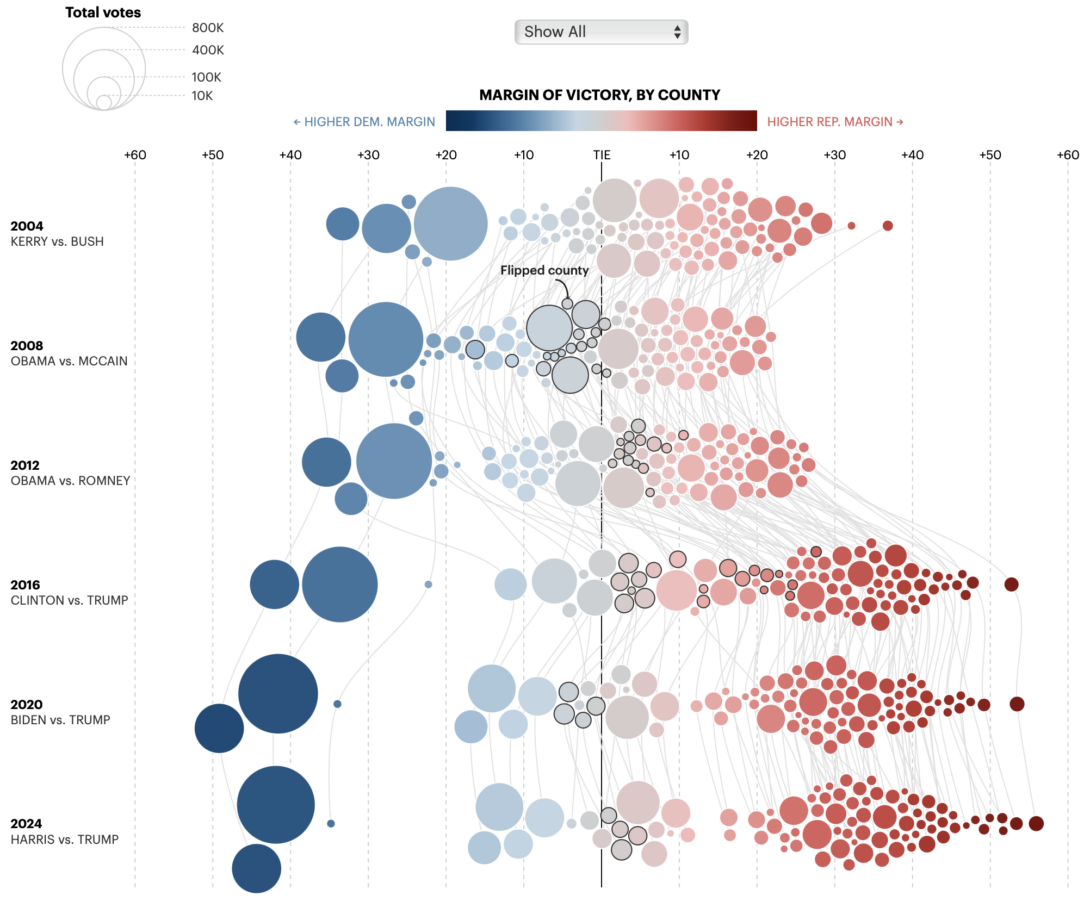


## 4. Mixed Content Analysis

In [18]:
import json
import urllib.request
from PIL import Image
from io import BytesIO
from voyageai import Client
import numpy as np

## Visit the real URL in Xbox Store: https://www.xbox.com/en-US/games/store/call-of-duty-black-ops-6-vault-edition-upgrade-windows/9N19RDPJHFLR/0010


# Helper function to load image from a URL
def load_image_from_url(url: str) -> Image.Image:
    with urllib.request.urlopen(url) as response:
        img_data = BytesIO(response.read())
    return Image.open(img_data)

# Define product metadata in JSON format, including the product image URL
product_metadata = {
    "title": "Call of Duty: Black Ops 6 Vault Edition Upgrade (Windows)",
    "description": "Experience intense violence, strong language, and thrilling multiplayer action. "
                   "Requires Xbox Game Pass for multiplayer on console.",
    "image_url": "https://store-images.s-microsoft.com/image/apps.25689.13909193928944040.073f4f1c-2a1f-4b23-bd2c-278a9a4a4755.72a4aa62-4cda-4a17-874a-abe1caed1db8?q=90&w=177&h=265",
    "minimum_requirements": {
        "os": "Windows 10 version 18362.0 or higher",
        "architecture": "x64"
    },
    "recommended_requirements": {
        "os": "Windows 10 version 18362.0 or higher",
        "architecture": "x64"
    },
    "additional_info": {
        "installation": "Install on your home Xbox One console plus have access when connected to your Microsoft account.",
        "approximate_size": "91.22 GB",
        "mature_rating": "Mature 17+",
        "features": [
            "Blood and Gore", 
            "Intense Violence", 
            "Strong Language", 
            "Suggestive Themes", 
            "Use of Drugs"
        ]
    }
}

# Convert JSON object to a string
product_metadata_str = json.dumps(product_metadata, indent=4)

# Extract the product image URL from the metadata
product_image_url = product_metadata["image_url"]

# Load the product image
product_image = load_image_from_url(product_image_url)

# Mixed-content document
mixed_document = [
    [product_metadata["description"], product_image, product_metadata_str]
]

# Generate embedding for the mixed-content document
MODEL_NAME = "voyage-multimodal-3"
mixed_embedding = voyage_client.multimodal_embed(
    inputs=mixed_document,
    model=MODEL_NAME,
    input_type="document"
).embeddings[0]

# Define mixed query archetypes
query_image_url = "https://store-images.s-microsoft.com/image/apps.25689.13909193928944040.073f4f1c-2a1f-4b23-bd2c-278a9a4a4755.72a4aa62-4cda-4a17-874a-abe1caed1db8?q=90&w=177&h=265"
query_feature_image_url = "https://images.unsplash.com/photo-1605899435973-ca2d1a8861cf?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8eGJveHxlbnwwfHwwfHx8MA%3D%3D" # Image of Xbox Gaming Controller

mixed_queries = [
    ["Find games like Call of Duty"],  # Text-only query
    ["Show me intense shooter games"],  # Another text query
    [load_image_from_url(query_image_url)],  # Image-only query
    ["Games compatible with this console", load_image_from_url(query_feature_image_url)]  # Text + image query
]

# Generate embeddings for mixed queries
query_embeddings = voyage_client.multimodal_embed(
    inputs=mixed_queries,
    model=MODEL_NAME,
    input_type="query"
).embeddings

# Calculate and print similarity scores
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

print("\nMixed Content Query Analysis:")
for i, query_embedding in enumerate(query_embeddings):
    sim = cosine_similarity(mixed_embedding, query_embedding)
    print(f"Query {i + 1} similarity: {sim:.4f}")



Mixed Content Query Analysis:
Query 1 similarity: 0.3488
Query 2 similarity: 0.2914
Query 3 similarity: 0.7156
Query 4 similarity: 0.4130


## 4. PDF Screenshot Analysis

In [9]:
import urllib.request
import urllib.parse
from PIL import Image
from io import BytesIO
import fitz  # PyMuPDF
import numpy as np
from tenacity import retry, stop_after_attempt, wait_exponential

@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
def fetch_pdf_data(pdf_url: str) -> bytes:
    """Fetch PDF data from the URL with retry logic."""
    encoded_pdf_url = urllib.parse.quote(pdf_url, safe=':/')
    with urllib.request.urlopen(encoded_pdf_url) as response:
        return response.read()

def pdf_to_screenshots(pdf_url: str, zoom: float = 1.0) -> list[Image.Image]:
    """Convert PDF pages to screenshots."""
    pdf_data = fetch_pdf_data(pdf_url)
    pdf_stream = BytesIO(pdf_data)
    pdf = fitz.open(stream=pdf_stream, filetype="pdf")
    
    images = []
    mat = fitz.Matrix(zoom, zoom)
    for page in pdf:
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
    
    pdf.close()
    return images

# Example PDF URL (replace with your PDF URL)
pdf_url = "https://ignite2024demo.blob.core.windows.net/state-of-ai-2024/State of AI Report 2024.pdf"
pdf_images = pdf_to_screenshots(pdf_url)

# Generate embeddings for each page
page_embeddings = voyage_client.multimodal_embed(
    inputs=[[img] for img in pdf_images],
    model=MODEL_NAME,
    input_type="document"
).embeddings

# Example query to find relevant pages
query = ["Find sections with bar charts about AI trends"]
query_embedding = voyage_client.multimodal_embed(
    inputs=[query],
    model=MODEL_NAME,
    input_type="query"
).embeddings[0]

# Find most relevant pages
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

similarities = [cosine_similarity(query_embedding, page_emb) for page_emb in page_embeddings]
most_relevant = np.argsort(similarities)[::-1]

print("\nMost relevant PDF pages:")
for i, page_idx in enumerate(most_relevant[:3]):
    print(f"Page {page_idx + 1}: Similarity = {similarities[page_idx]:.4f}")


Most relevant PDF pages:
Page 149: Similarity = 0.3926
Page 109: Similarity = 0.3892
Page 108: Similarity = 0.3764


Here are screenshots of those pages for reference:
page_149.jpg:
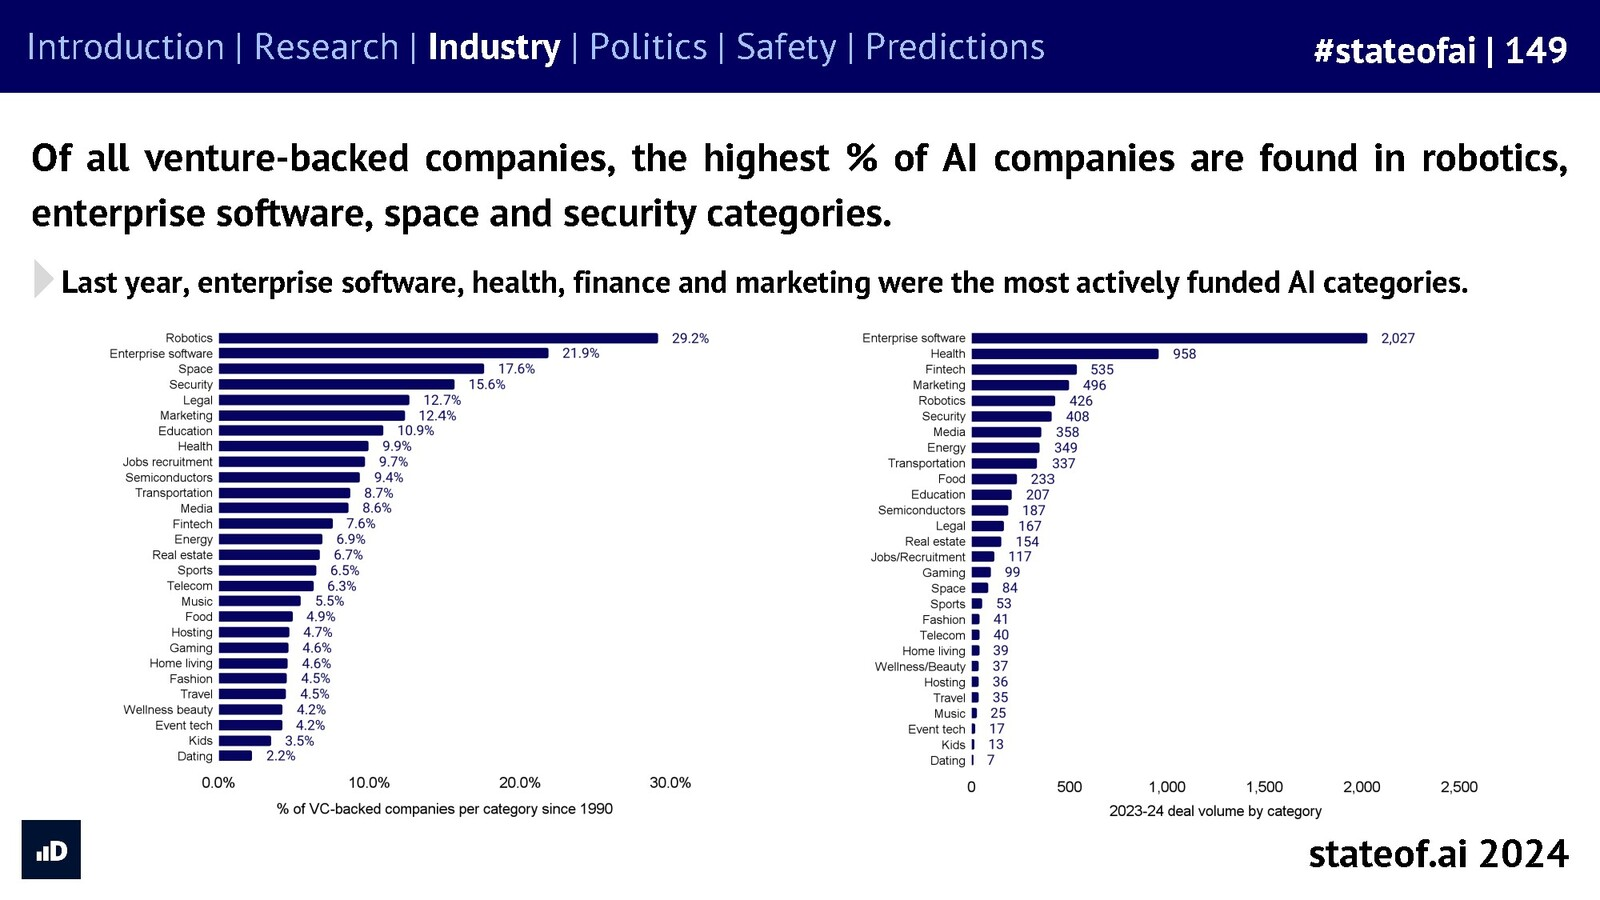

page_109.jpg:
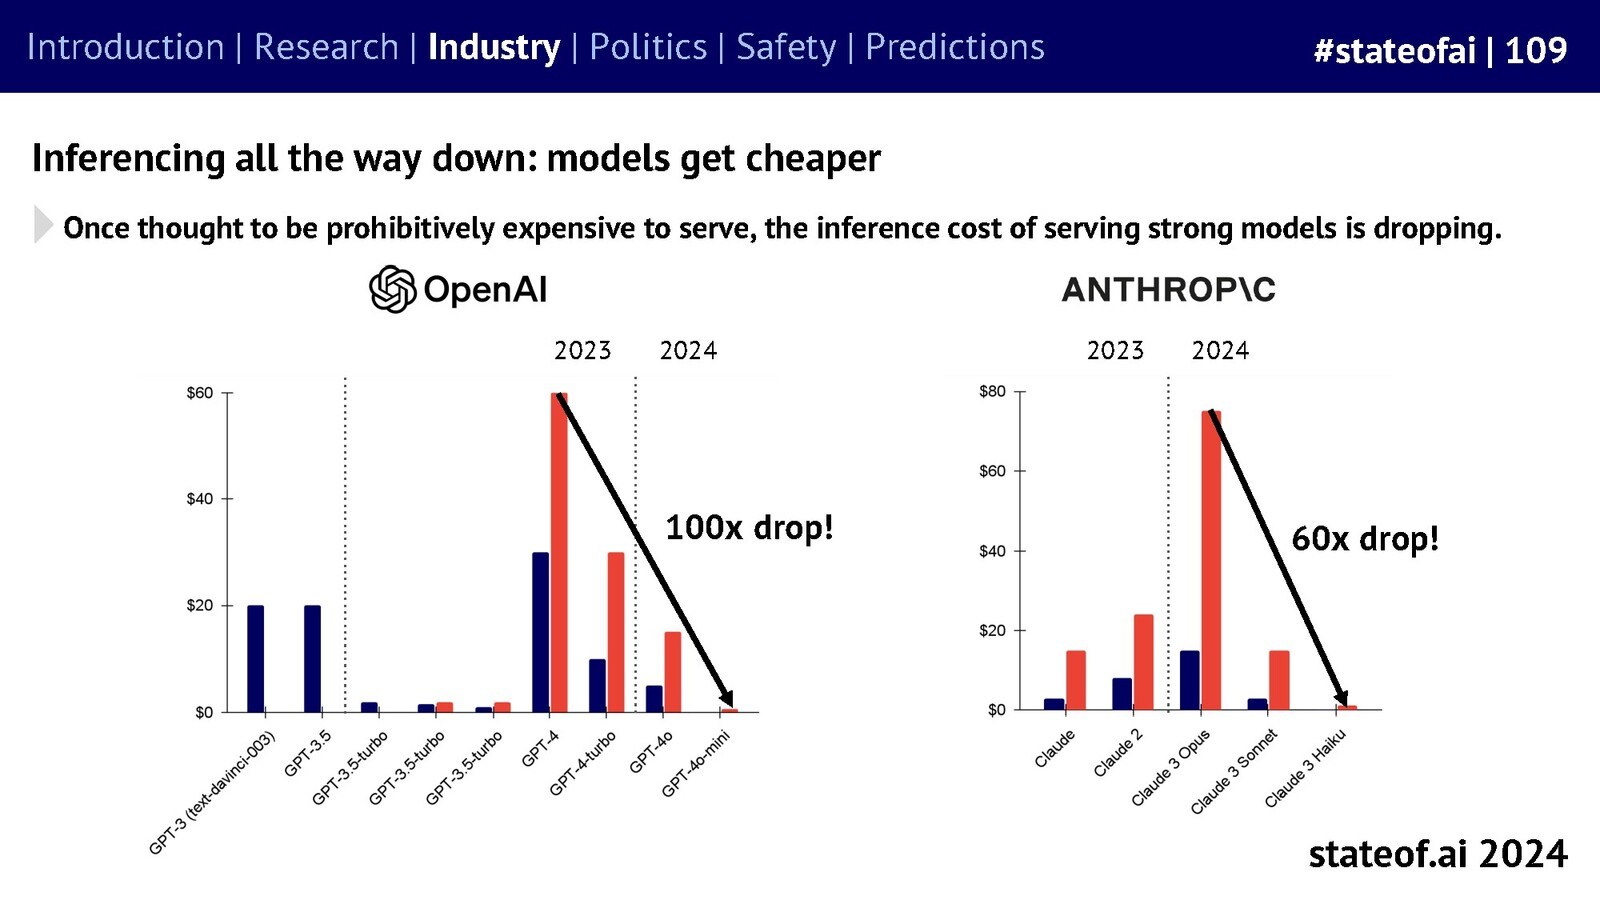

page_108,jpg:
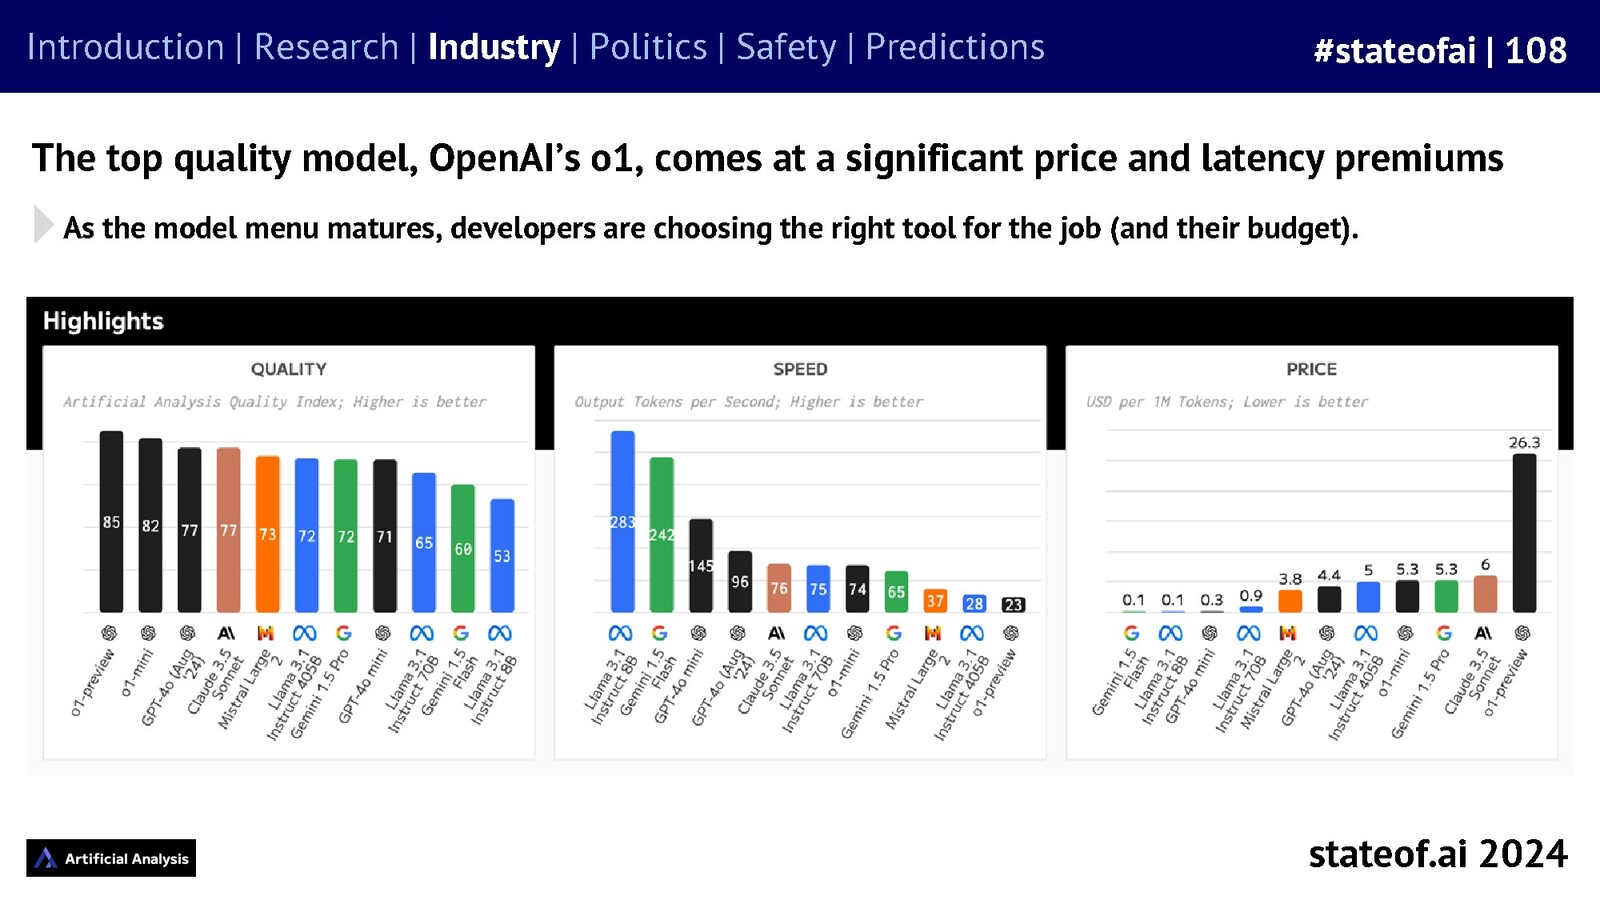

After analyzing the full PDF, these 3 images I would say are indeed the most representative of the query: "Find sections with bar charts about AI trends"

In [ ]:
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import *
from azure.search.documents.models import VectorizedQuery

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),
    SimpleField(name="pdf_url", type=SearchFieldDataType.String),
    SimpleField(name="page_number", type=SearchFieldDataType.Int32, filterable=True),
    SearchField(
        name="embedding",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        searchable=True,
        vector_search_dimensions=1024,
        vector_search_profile_name="vector_profile"
    )
]

vector_search = VectorSearch(
    algorithms=[
        ExhaustiveKnnAlgorithmConfiguration(
            name="exhaustive_config",
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="vector_profile",
            algorithm_configuration_name="exhaustive_config"
        )
    ]
)

index = SearchIndex(
    name=INDEX_NAME,
    fields=fields,
    vector_search=vector_search
)

index_client.create_or_update_index(index)

documents = []
for page_num, embedding in enumerate(page_embeddings):
    doc = {
        "id": f"state_of_ai_2024_page_{page_num + 1}",
        "pdf_url": pdf_url,
        "page_number": page_num + 1,
        "embedding": embedding  
    }
    documents.append(doc)

try:
    result = search_client.upload_documents(documents=documents)
    print(f"Successfully uploaded {len(documents)} PDF pages")
except Exception as e:
    print(f"Error uploading documents: {e}")


In [ ]:
def search_pdf_pages(query_text: str, top_k: int = 3):
    # Generate query embedding
    query_result = voyage_client.multimodal_embed(
        inputs=[[query_text]], model=MODEL_NAME, input_type="query"
    )
    query_vector = query_result.embeddings[0]

    # Create vector query
    vector_query = VectorizedQuery(
        vector=query_vector, k_nearest_neighbors=top_k, fields="embedding"
    )

    # Perform search
    results = search_client.search(
        search_text=None,
        vector_queries=[vector_query],
        select=["id", "pdf_url", "page_number"],
    )

    return list(results)


print("\nSearching for pages with bar charts about AI trends:")
results = search_pdf_pages("Find sections with bar charts about AI trends")
for r in results:
    print(f"Page {r['page_number']}, Score: {r['@search.score']}")